## MOVIE RATING PREDICTION

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from xgboost import XGBRegressor


In [3]:
# Load the dataset
movie = pd.read_csv("C:/Users/akinw/Downloads/indiamovies.csv", encoding='cp1252')
movie.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [4]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


## Handling missing values

In [6]:
# check for missing values
movie.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [7]:
movie = movie[~movie['Rating'].isnull()]   # Rating missing values will be dropped since it is the value I am predicting, therefore, it cannot be imputed
movie['Genre'] = movie['Genre'].fillna('unknown')   # for Genre
movie['Director'] = movie['Director'].fillna('unknown')   # for Director
movie['Actor 1'] = movie['Actor 1'].fillna('unknown')   # for Actor 1
movie['Actor 2'] = movie['Actor 2'].fillna('unknown')   # for Actor 2
movie['Actor 3'] = movie['Actor 3'].fillna('unknown')   # for Actor 3

In [8]:
# for year
movie['Year'] = movie['Year'].astype(str) #convert to string first
movie['Year'] = movie['Year'].str.extract(r'(\d{4})') #extract year
movie['Year'] = pd.to_numeric(movie['Year'], errors='coerce') #convert to numeric
year_mode = movie['Year'].mode()

if not year_mode.empty:
    movie['Year'] = movie['Year'].fillna(year_mode[0])
else:
    movie['Year'] = movie['Year'].fillna(2022)

In [9]:
# for votes
movie['Votes'] = pd.to_numeric(movie['Votes'].str.replace(',', ''), errors='coerce')
movie['Votes'] = movie['Votes'].fillna(movie['Votes'].median())

In [10]:
movie.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142 min,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [11]:
movie['Duration'].isnull().sum()

2068

In [12]:
# handling missing value for duration
movie['Duration'] = movie['Duration'].str.replace('min', '').str.strip()
movie['Duration'] = pd.to_numeric(movie['Duration'], errors = 'coerce')
movie['Duration'] = movie['Duration'].fillna(movie['Duration'].median())

In [13]:
movie.isnull().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [14]:
movie.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [15]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7919 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7919 non-null   object 
 1   Year      7919 non-null   int64  
 2   Duration  7919 non-null   float64
 3   Genre     7919 non-null   object 
 4   Rating    7919 non-null   float64
 5   Votes     7919 non-null   int64  
 6   Director  7919 non-null   object 
 7   Actor 1   7919 non-null   object 
 8   Actor 2   7919 non-null   object 
 9   Actor 3   7919 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 680.5+ KB


## Check for Outliers in the numeric columns

In [17]:
numeric_columns = movie.select_dtypes(include = 'number')
numeric_columns.head()

,Year,Duration,Rating,Votes
1,2019,109.0,7.0,8
3,2019,110.0,4.4,35
5,1997,147.0,4.7,827
6,2005,142.0,7.4,1086
8,2012,82.0,5.6,326


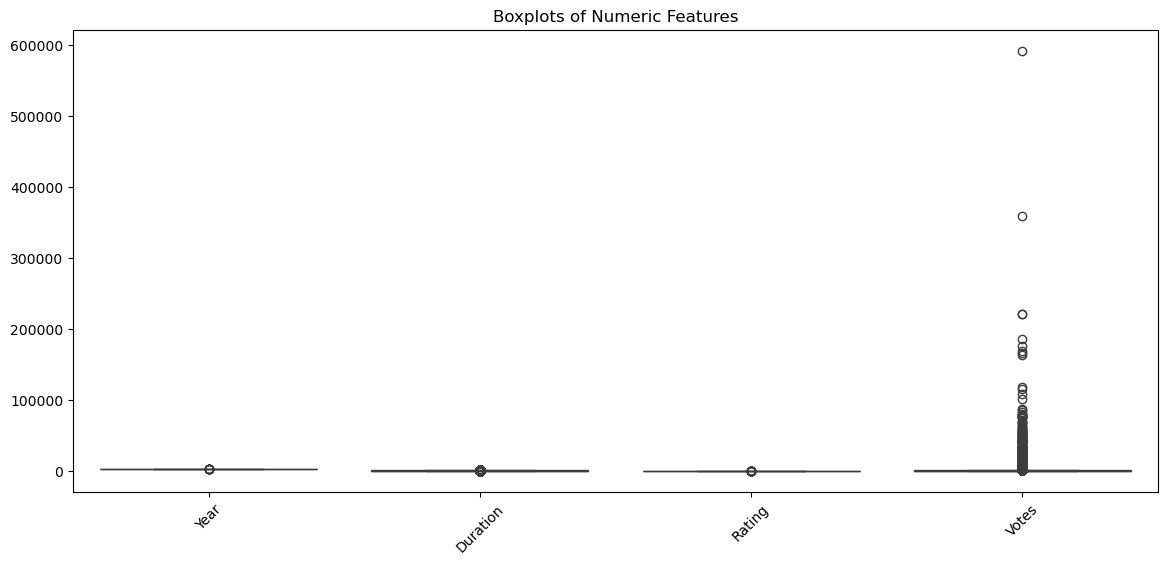

In [18]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=numeric_columns)
plt.xticks(rotation=45)
plt.title("Boxplots of Numeric Features")
plt.show()


## check for duplicates

In [20]:
movie.duplicated().sum()

0

In [21]:
movie.isnull().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [22]:
movie.to_csv('cleaned_movie')

## Feature Engineering

In [24]:
# Fill missing Ratings with the overall mean rating (precaution before grouping)
overall_mean_rating = movie['Rating'].mean()
movie['Rating'] = movie['Rating'].fillna(overall_mean_rating)

# --- Target encoding for Director and Actors with fallback to overall mean ---
director_mean_rating = movie.groupby('Director')['Rating'].mean()
movie['Director_encoded'] = movie['Director'].map(director_mean_rating).fillna(overall_mean_rating)

actor1_mean_rating = movie.groupby('Actor 1')['Rating'].mean()
movie['Actor1_encoded'] = movie['Actor 1'].map(actor1_mean_rating).fillna(overall_mean_rating)

actor2_mean_rating = movie.groupby('Actor 2')['Rating'].mean()
movie['Actor2_encoded'] = movie['Actor 2'].map(actor2_mean_rating).fillna(overall_mean_rating)

actor3_mean_rating = movie.groupby('Actor 3')['Rating'].mean()
movie['Actor3_encoded'] = movie['Actor 3'].map(actor3_mean_rating).fillna(overall_mean_rating)

# --- One-hot encoding Genre safely ---
# Ensure 'Genre' column has no null before splitting
movie['Genre'] = movie['Genre'].fillna('unknown')

# Create list of genres per movie
movie['Genre_list'] = movie['Genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else ['unknown'])

# MultiLabelBinarizer for one-hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movie['Genre_list'])

# Convert to DataFrame and merge
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
movie = pd.concat([movie.reset_index(drop=True), genre_df.reset_index(drop=True)], axis=1)


In [25]:
movie.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,unknown
0,#Gadhvi (He thought he was Gandhi),2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,...,0,0,0,0,0,0,0,0,0,0
1,#Yaaram,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,...,0,0,0,1,0,0,0,0,0,0
2,...Aur Pyaar Ho Gaya,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,...,1,0,0,0,0,0,0,0,0,0
3,...Yahaan,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,...,0,0,0,1,0,0,0,1,0,0
4,?: A Question Mark,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,...,0,1,0,0,0,0,1,0,0,0


In [26]:
movie.isnull().sum()

Name                0
Year                0
Duration            0
Genre               0
Rating              0
Votes               0
Director            0
Actor 1             0
Actor 2             0
Actor 3             0
Director_encoded    0
Actor1_encoded      0
Actor2_encoded      0
Actor3_encoded      0
Genre_list          0
Action              0
Adventure           0
Animation           0
Biography           0
Comedy              0
Crime               0
Documentary         0
Drama               0
Family              0
Fantasy             0
History             0
Horror              0
Music               0
Musical             0
Mystery             0
News                0
Romance             0
Sci-Fi              0
Sport               0
Thriller            0
War                 0
Western             0
unknown             0
dtype: int64

In [27]:
movie.columns

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3', 'Director_encoded', 'Actor1_encoded',
       'Actor2_encoded', 'Actor3_encoded', 'Genre_list', 'Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western',
       'unknown'],
      dtype='object')

In [28]:
movies = movie.copy()

In [29]:
# drop unnecessary columns
movies.drop(['Name', 'Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre_list'], axis=1, inplace=True)

In [30]:
movies.head()

,Year,Duration,Rating,Votes,Director_encoded,Actor1_encoded,Actor2_encoded,Actor3_encoded,Action,Adventure,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,unknown
0,2019,109.0,7.0,8,7.000000,6.850000,7.000000,7.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019,110.0,4.4,35,4.400000,5.420000,4.400000,4.450000,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1997,147.0,4.7,827,5.358824,4.788889,5.786667,5.846154,0,0,...,1,0,0,0,0,0,0,0,0,0
3,2005,142.0,7.4,1086,7.500000,5.356000,6.050000,6.500000,0,0,...,0,0,0,1,0,0,0,1,0,0
4,2012,82.0,5.6,326,5.600000,5.600000,5.883333,5.600000,0,0,...,0,1,0,0,0,0,1,0,0,0


In [31]:
movies.shape

(7919, 31)

In [32]:
print(movies.isnull().sum())

Year                0
Duration            0
Rating              0
Votes               0
Director_encoded    0
Actor1_encoded      0
Actor2_encoded      0
Actor3_encoded      0
Action              0
Adventure           0
Animation           0
Biography           0
Comedy              0
Crime               0
Documentary         0
Drama               0
Family              0
Fantasy             0
History             0
Horror              0
Music               0
Musical             0
Mystery             0
News                0
Romance             0
Sci-Fi              0
Sport               0
Thriller            0
War                 0
Western             0
unknown             0
dtype: int64


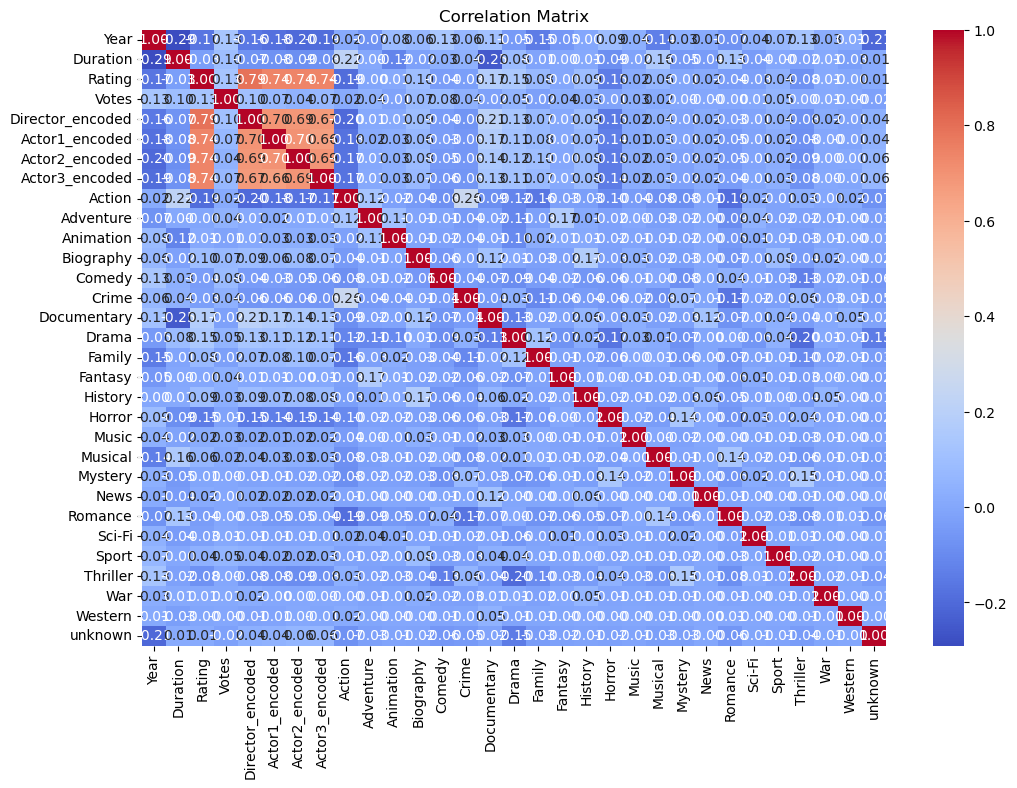

In [33]:
#check the variables that are correlated with Rating
corr_matrix = movies.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [34]:
#Isolate the features that correlate
corr_with_target = corr_matrix['Rating'].sort_values(ascending=False)
print(corr_with_target)

Rating              1.000000
Director_encoded    0.792327
Actor3_encoded      0.739837
Actor1_encoded      0.738537
Actor2_encoded      0.738484
Documentary         0.173885
Drama               0.145638
Votes               0.126635
Biography           0.095655
History             0.089342
Family              0.077348
Musical             0.059060
Sport               0.038021
Music               0.018880
News                0.016201
unknown             0.013013
War                 0.009484
Animation           0.007996
Fantasy            -0.002609
Western            -0.003874
Adventure          -0.004060
Mystery            -0.006366
Sci-Fi             -0.028198
Duration           -0.030474
Crime              -0.033275
Romance            -0.035512
Comedy             -0.038130
Thriller           -0.077962
Horror             -0.146410
Year               -0.166673
Action             -0.193820
Name: Rating, dtype: float64


In [35]:
# selecting the useful features
selected_features = ['Director_encoded', 'Actor1_encoded', 'Actor2_encoded', 'Actor3_encoded', 'Votes']

In [36]:
selected_features

['Director_encoded',
 'Actor1_encoded',
 'Actor2_encoded',
 'Actor3_encoded',
 'Votes']

## Train-Test Split, Modeling and Evaluation

In [38]:
X = movies[selected_features]
y = movies['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
#Linear Regression
lr=LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = mean_squared_error(y_test, y_pred_lr, squared=False)

# Print results
print("Linear Regression Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Linear Regression Performance Metrics:
R² Score: 0.7537
MAE: 0.4963
RMSE: 0.6766


C:\Users\akinw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
# Ridge Regression with hyper paraameter Tunning
ridge = Ridge()
ridge_params = {'alpha':[0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_

y_pred_ridge = ridge_grid.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_ridge)
mae = mean_absolute_error(y_test, y_pred_ridge)
rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)

# Print results
print("Ridge Regression Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Ridge Regression Performance Metrics:
R² Score: 0.7537
MAE: 0.4963
RMSE: 0.6766


C:\Users\akinw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
# Using Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)

# Print results
print("Random Forest Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Random Forest Performance Metrics:
R² Score: 0.7900
MAE: 0.4210
RMSE: 0.6248


C:\Users\akinw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [42]:
# Initialize XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

# Grid search with 3-fold cross-validation
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

# Get best model
best_xgb = xgb_grid.best_estimator_

# Predict on test data
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)

# Print results
print("XGBoost Regression Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
XGBoost Regression Performance Metrics:
R² Score: 0.7866
MAE: 0.4465
RMSE: 0.6298


C:\Users\akinw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## comparing the models above by viualisation

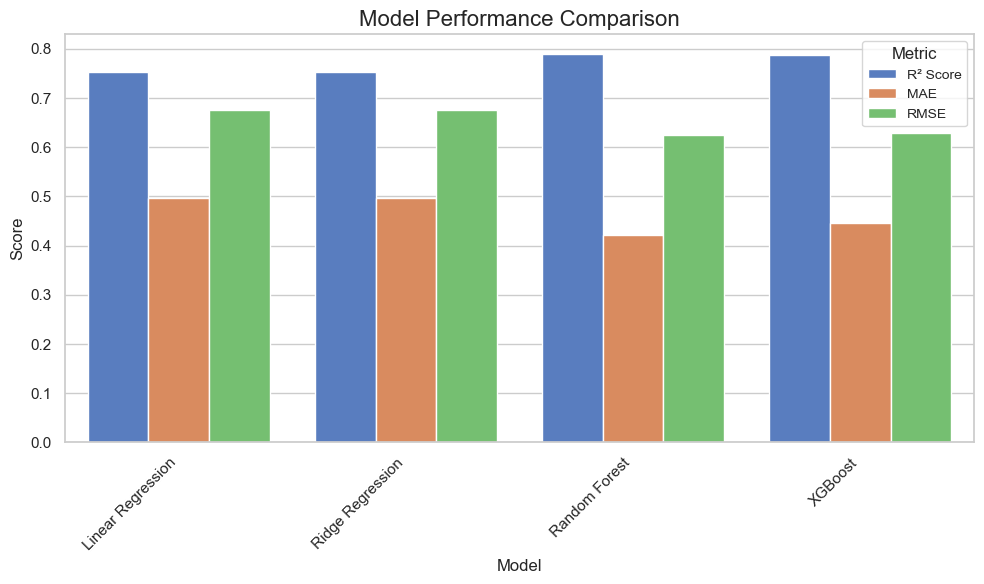

In [44]:
# Creating a DataFrame for the results
data = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Random Forest', 'XGBoost'],
    'R² Score': [0.7537, 0.7537, 0.7900, 0.7866],
    'MAE': [0.4963, 0.4963, 0.4210, 0.4465],
    'RMSE': [0.6766, 0.6766, 0.6248, 0.6298]
}

df = pd.DataFrame(data)

# Melt the DataFrame for better plotting with seaborn
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set the figure size for a professional look
plt.figure(figsize=(10, 6))

# Create the barplot
sns.set(style="whitegrid")
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette='muted')

# Customize the plot
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Metric', title_fontsize=12, fontsize=10)
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()

In [45]:
## from above, Random Forest is the best model

## Plotting Actual vs Predicted Value

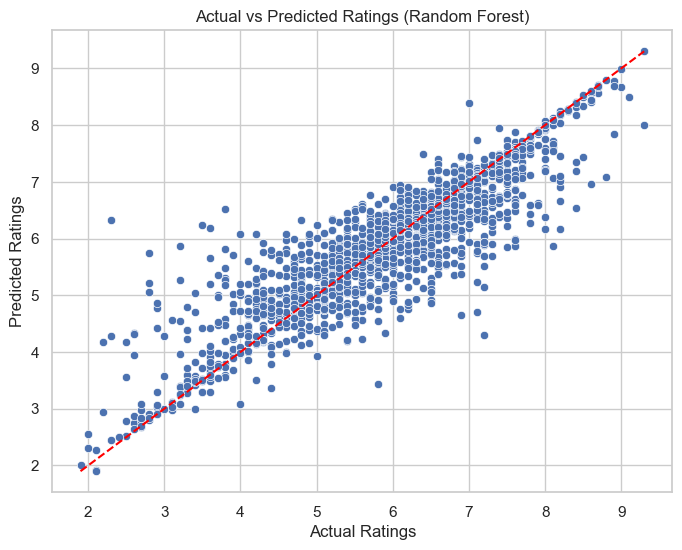

In [47]:
# Plotting Actual vs Predicted Value

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # ideal line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings (Random Forest)')
plt.grid(True)
plt.show()


## Residual plots

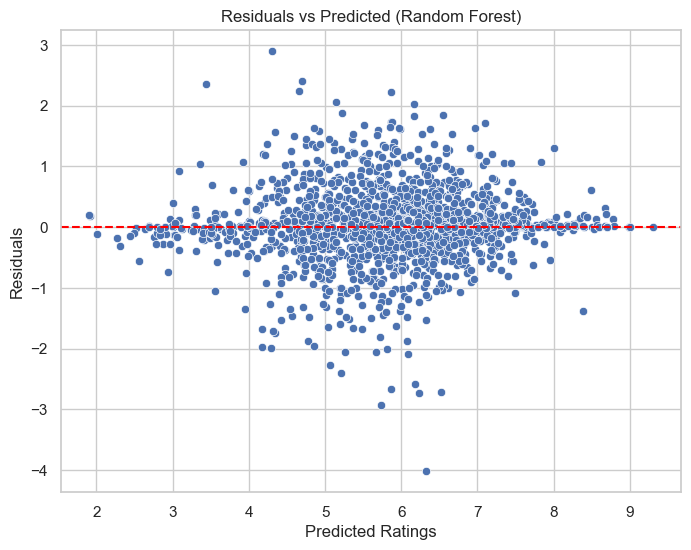

In [49]:
residuals = y_test - y_pred_rf

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Random Forest)')
plt.grid(True)
plt.show()


## The most influenced features

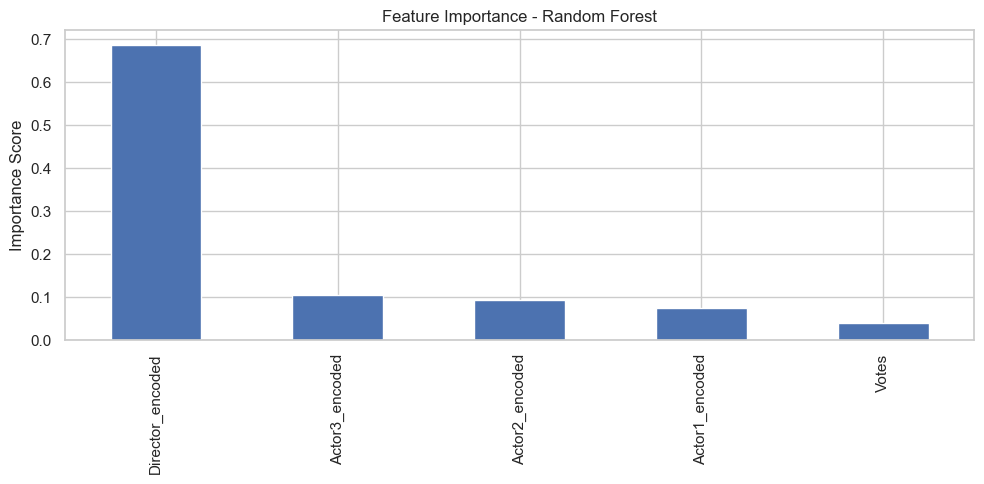

In [51]:
# which features influenced the prediction most
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title("Feature Importance - Random Forest")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()
